In [70]:
from pathlib import Path
import os
workdir = Path("/ibstorage/anthony/NYS_Wetlands_GHG/")
print(workdir)
os.chdir(workdir)
current_working_dir = Path.cwd()
print(f"Current working directory is now: {current_working_dir}")

/ibstorage/anthony/NYS_Wetlands_GHG
Current working directory is now: /ibstorage/anthony/NYS_Wetlands_GHG


In [71]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pathlib import Path
import sys

In [72]:
# === PATHS ===
workdir = Path("/ibstorage/anthony/NYS_Wetlands_GHG/")
script_dir = Path("/ibstorage/anthony/NYS_Wetlands_GHG/Python_Code_Analysis/DL_Learning")
sys.path.insert(0, str(script_dir))

from _04_dataset import WetlandDataset
from _05_unet_model import UNet

In [73]:
# === LOAD MODEL ===
device = torch.device("cpu")
model = UNet(in_channels=8, num_classes=5, base_filters=32)

checkpoint = torch.load(workdir / "Models/final_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded model from epoch {checkpoint['epoch'] + 1}")
print(f"Validation loss: {checkpoint['val_loss']:.4f}")
print(f"Validation accuracy: {checkpoint['val_acc']:.4f}")

Loaded model from epoch 11
Validation loss: 1.2488
Validation accuracy: 0.3962


/tmp/ipykernel_2622967/277347977.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(workdir / "Models/final_model.pth", map_location=device)


In [74]:
# === LOAD VALIDATION DATA ===
val_dataset = WetlandDataset(
    workdir / "Data/Patches_v2/X_val.npy",
    workdir / "Data/Patches_v2/y_val.npy",
    normalize=True
)

In [75]:
# === VISUALIZATION SETUP ===
class_names = ['Background', 'EMW', 'FSW', 'SSW', 'OWW']
colors = ['white', 'green', 'darkgreen', 'orange', 'blue']
cmap = ListedColormap(colors)

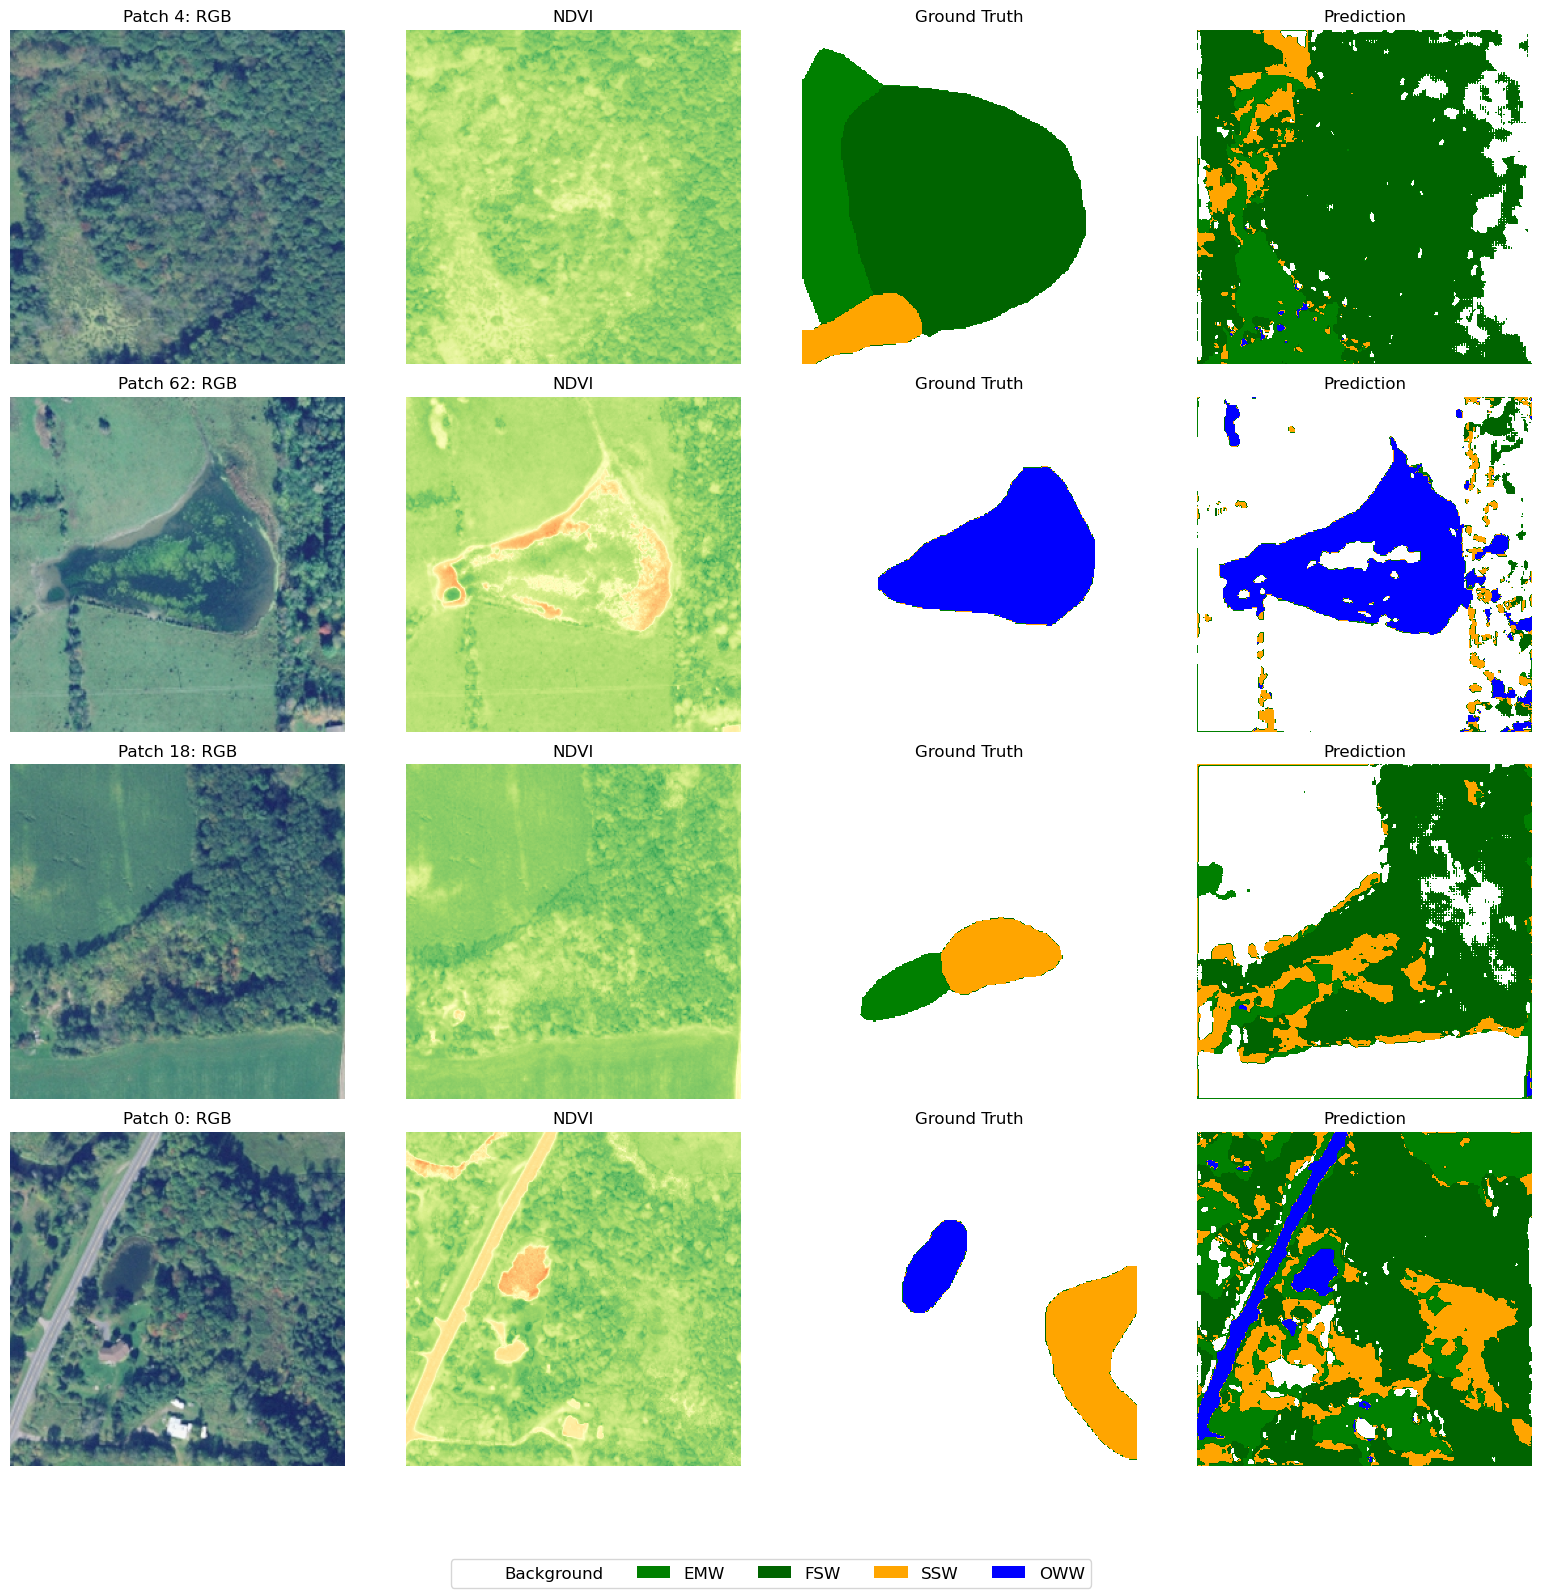


Saved visualization to Models/prediction_samples.png


In [81]:
# === PLOT SAMPLE PREDICTIONS ===
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

# Select 4 random validation patches
np.random.seed(42)
indices = np.random.choice(len(val_dataset), 4, replace=False)
# print(indices)
for row, idx in enumerate(indices):
    X, y_true = val_dataset[idx]
    
    # Get prediction
    with torch.no_grad():
        output = model(X.unsqueeze(0))  # Add batch dimension
        y_pred = torch.argmax(output, dim=1).squeeze().numpy()
    
    # Convert tensors to numpy for plotting
    y_true = y_true.numpy()
    
    # RGB image (denormalize)
    rgb = X[0:3].numpy().transpose(1, 2, 0)  # Already 0-1 from normalization
    
    # Plot RGB
    axes[row, 0].imshow(rgb)
    axes[row, 0].set_title(f"Patch {idx}: RGB")
    axes[row, 0].axis('off')
    
    # Plot NDVI
    ndvi = X[4].numpy()
    axes[row, 1].imshow(ndvi, cmap='RdYlGn', vmin=0, vmax=1)
    axes[row, 1].set_title("NDVI")
    axes[row, 1].axis('off')
    
    # Plot ground truth
    axes[row, 2].imshow(y_true, cmap=cmap, vmin=0, vmax=4)
    axes[row, 2].set_title("Ground Truth")
    axes[row, 2].axis('off')
    
    # Plot prediction
    axes[row, 3].imshow(y_pred, cmap=cmap, vmin=0, vmax=4)
    axes[row, 3].set_title("Prediction")
    axes[row, 3].axis('off')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=n) for c, n in zip(colors, class_names)]
fig.legend(handles=legend_elements, loc='lower center', ncol=5, fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.08)
plt.savefig(workdir / "Models/prediction_samples.png", dpi=150)
plt.show()

print(f"\nSaved visualization to Models/prediction_samples.png")